In [1]:
import hashlib
import random
from sympy import isprime
from sympy import mod_inverse
import time
import matplotlib.pyplot as plt
import json
import math
from Crypto.Util import number

In [2]:
import ast

with open('claveRSA', 'r') as file:
    provided_values = file.read()

provided_values_dict = ast.literal_eval(provided_values)
provided_values = ast.literal_eval(provided_values_dict)

In [3]:
class rsa_key:
    def obtener_primos(self, bits_modulo):
        p_es_primo = False
        q_es_primo = False
        p_q_igual = True
        p_q_coprimos = False
        primeP = 0
        primeQ = 0

        while ((not p_q_coprimos) or (p_q_igual)):
            while (not p_es_primo):
                primeP = random.randint(0, 2**(bits_modulo >> 1))
                p_es_primo = isprime(primeP)
            while (not q_es_primo):
                primeQ = random.randint(0, 2**(bits_modulo >> 1))
                q_es_primo = isprime(primeQ)
            p_q_igual = (primeQ == primeP)
            p_q_coprimos = (math.gcd(self.publicExponent, ((primeP - 1) * (primeQ - 1))) == 1)

        return primeP, primeQ

    def __init__(self, bits_modulo=2048, e=2**16 + 1):
        """
        Genera una clave RSA (de 2048 bits y exponente público 2**16+1 por defecto).
        """
        self.publicExponent = e
        self.primeP, self.primeQ = self.obtener_primos(bits_modulo)
        # self.primeP = provided_values['primeP']
        # self.primeQ = provided_values['primeQ']
        self.modulus = self.primeP * self.primeQ
        
        phi = (self.primeP - 1) * (self.primeQ - 1)
        self.privateExponent = int(mod_inverse(self.publicExponent, phi))
        
        self.inverseQModulusP = int(mod_inverse(self.primeQ, self.primeP))
        self.privateExponentModulusPhiP = int(self.privateExponent % (self.primeP - 1))
        self.privateExponentModulusPhiQ = int(self.privateExponent % (self.primeQ - 1))

    def __repr__(self):
        return str(self.__dict__)

    def sign(self, message):
        """
        Realiza una firma utilizando la clave privada con el Teorema Chino del Resto (TCR).
        """
        mP = pow(message, self.privateExponentModulusPhiP, self.primeP)
        mQ = pow(message, self.privateExponentModulusPhiQ, self.primeQ)
        h = ((mP - mQ) * self.inverseQModulusP) % self.primeP
        m = (mQ + h * self.primeQ) % self.modulus
        return m

    def sign_slow(self, message):
        """
        Realiza una firma utilizando la clave privada directamente (sin TCR).
        """
        m = pow(message, self.privateExponent, self.modulus)
        return m
    
    def from_dictionary(self, clave):
        self.publicExponent = clave['publicExponent']
        self.primeP = clave['primeP']
        self.primeQ = clave['primeQ']
        self.modulus = clave['modulus']
        self.privateExponent = clave['privateExponent']
        self.inverseQModulusP = clave['inverseQModulusP']
        self.privateExponentModulusPhiP = clave['privateExponentModulusPhiP']
        self.privateExponentModulusPhiQ = clave['privateExponentModulusPhiQ']
        
    def to_dict(self):
        """
        Convierte el objeto rsa_key a un diccionario.
        """
        return {
            'publicExponent': self.publicExponent,
            'primeP': self.primeP,
            'primeQ': self.primeQ,
            'modulus': self.modulus,
            'privateExponent': self.privateExponent,
            'inverseQModulusP': self.inverseQModulusP,
            'privateExponentModulusPhiP': self.privateExponentModulusPhiP,
            'privateExponentModulusPhiQ': self.privateExponentModulusPhiQ
        }

class rsa_public_key:
    def __init__(self, publicExponent=1, modulus=1):
        """
        Genera la clave pública RSA asociada a la clave RSA privada.
        """
        self.publicExponent = publicExponent
        self.modulus = modulus

    def __repr__(self):
        return str(self.__dict__)

    def verify(self, message, signature):
        """
        Verifica que la firma corresponde al mensaje con la clave pública.
        """
        return pow(signature, self.publicExponent, self.modulus) == message

    def to_dict(self):
        """
        Convierte el objeto rsa_public_key a un diccionario.
        """
        return {
            'publicExponent': self.publicExponent,
            'modulus': self.modulus
        }


class transaction:
    def __init__(self, message = 0, RSAkey = 0):
        """
        Crea una transacción firmando 'message' con la clave privada RSAkey.
        """
        if isinstance(RSAkey, int):
            return
        self.message = message
        self.public_key = rsa_public_key(RSAkey.publicExponent, RSAkey.modulus)
        self.signature = RSAkey.sign(message)

    def __repr__(self):
        return str(self.__dict__)

    def verify(self):
        """
        Verifica que la firma sea válida con la clave pública.
        """
        return self.public_key.verify(self.message, self.signature)
    
    def from_dictionary(self, transaccion):
        self.public_key = rsa_public_key(
            publicExponent=transaccion['public_key']['publicExponent'],
            modulus=transaccion['public_key']['modulus']
        )
        self.message = transaccion['message']
        self.signature = transaccion['signature']
        
    def to_dict(self):
        """
        Convierte el objeto transaction a un diccionario.
        """
        return {
            'public_key': self.public_key.to_dict(),
            'message': self.message,
            'signature': self.signature
        }
        

In [4]:
def eval_rsa_key(fichero_de_entrada=''):
    with open(fichero_de_entrada, 'r') as file:
        clave_aux = eval(json.loads(file.read()))
    clave_rsa = rsa_key()
    clave_rsa.from_dictionary(clave_aux)

    evalN = clave_rsa.modulus == clave_rsa.primeP * clave_rsa.primeQ
    evalD = clave_rsa.privateExponent == number.inverse(clave_rsa.publicExponent, (clave_rsa.primeP - 1) * (clave_rsa.primeQ - 1))
    evalDModPhiP = clave_rsa.privateExponentModulusPhiP == clave_rsa.privateExponent % (clave_rsa.primeP - 1)
    evalDModPhiQ = clave_rsa.privateExponentModulusPhiQ == clave_rsa.privateExponent % (clave_rsa.primeQ - 1)
    evalInvQModP = clave_rsa.inverseQModulusP == number.inverse(clave_rsa.primeQ, clave_rsa.primeP)

    return evalN and evalD and evalDModPhiP and evalDModPhiQ and evalInvQModP

eval_rsa_key('claveRSA')


True

In [5]:
# Crear una instancia de la clase rsa_key
rsa_instance = rsa_key(bits_modulo=2048)

# Comparar los valores generados con los valores proporcionados
comparison_results = {
    'publicExponent': rsa_instance.publicExponent == provided_values['publicExponent'],
    'privateExponent': rsa_instance.privateExponent == provided_values['privateExponent'],
    'modulus': rsa_instance.modulus == provided_values['modulus'],
    'primeP': rsa_instance.primeP == provided_values['primeP'],
    'primeQ': rsa_instance.primeQ == provided_values['primeQ'],
    'privateExponentModulusPhiP': rsa_instance.privateExponentModulusPhiP == provided_values['privateExponentModulusPhiP'],
    'privateExponentModulusPhiQ': rsa_instance.privateExponentModulusPhiQ == provided_values['privateExponentModulusPhiQ'],
    'inverseQModulusP': rsa_instance.inverseQModulusP == provided_values['inverseQModulusP']
}

# Imprimir los resultados de la comparación
print(comparison_results)

{'publicExponent': True, 'privateExponent': False, 'modulus': False, 'primeP': False, 'primeQ': False, 'privateExponentModulusPhiP': False, 'privateExponentModulusPhiQ': False, 'inverseQModulusP': False}


In [6]:
# Importa las funciones necesarias
from sympy import isprime

# Pruebas para la clase rsa_key
def test_rsa_key():
    print("=== Probando generación de claves ===")
    rsa = rsa_key(bits_modulo=2048)  # Genera una clave RSA
    print("Claves generadas.")
    
    # Verifica si los números primos son válidos
    assert isprime(rsa.primeP), "primeP no es primo"
    assert isprime(rsa.primeQ), "primeQ no es primo"
    print("Los números primos son válidos.")
    
    # Verifica el cálculo de phi y el inverso
    phi = (rsa.primeP - 1) * (rsa.primeQ - 1)
    assert (rsa.publicExponent * rsa.privateExponent) % phi == 1, "El exponente privado no es el inverso modular"
    print("El exponente privado es correcto.")

def test_sign_and_verify():
    print("\n=== Probando firma y verificación ===")
    rsa = rsa_key(bits_modulo=2048)
    message = 42  # Mensaje de prueba
    
    # Firma rápida
    signature = rsa.sign(message)
    # Firma lenta
    signature_slow = rsa.sign_slow(message)
    assert signature == signature_slow, "Las firmas rápida y lenta no coinciden"
    print("La firma rápida y lenta coinciden.")
    
    # Verificación con la clave pública
    public_key = rsa_public_key(rsa.publicExponent, rsa.modulus)
    assert public_key.verify(message, signature), "La verificación falló"
    print("La verificación es exitosa.")

def test_transaction():
    print("\n=== Probando transacciones ===")
    rsa = rsa_key(bits_modulo=2048)
    message = 123456789  # Mensaje de prueba
    
    # Crear y verificar una transacción
    tx = transaction(message, rsa)
    assert tx.verify(), "La transacción no es válida"
    print("La transacción es válida.")

# Ejecuta las pruebas
if __name__ == "__main__":
    test_rsa_key()
    test_sign_and_verify()
    test_transaction()
    print("\nTodas las pruebas pasaron exitosamente.")


=== Probando generación de claves ===
Claves generadas.
Los números primos son válidos.
El exponente privado es correcto.

=== Probando firma y verificación ===
La firma rápida y lenta coinciden.
La verificación es exitosa.

=== Probando transacciones ===
La transacción es válida.

Todas las pruebas pasaron exitosamente.


In [7]:
D = 16 

class block:
    def __init__(self):
        '''
        crea un bloque (no necesariamente válido)
        '''
        self.block_hash = None
        self.previous_block_hash = None
        self.transaction = None
        self.seed = None

    def __repr__(self):
        return str(self.__dict__)
    
    def generateBlockHash(block):
        while True:
            block.seed = random.randint(0, 2**256)
            
            entrada = str(block.previous_block_hash)
            entrada = entrada+str(block.transaction.public_key.publicExponent)
            entrada = entrada+str(block.transaction.public_key.modulus)   
            entrada = entrada+str(block.transaction.message)
            entrada = entrada+str(block.transaction.signature)
            entrada = entrada+str(block.seed)
            entrada = int(hashlib.sha256(entrada.encode()).hexdigest(),16)
            
            if entrada < 2 ** (256 - D):
                break
            
        block.block_hash = entrada

    def genesis(self, transaction):
        '''
        genera el primer bloque de una cadena con la transacción "transaction"
        que se caracteriza por:
        - previous_block_hash=0
        - ser válido
        '''
        self.previous_block_hash = 0
        self.transaction = transaction
        self.generateBlockHash()
        return self

    def next_block(self, transaction):
        '''
        genera un bloque válido siguiente al actual con la transacción "transaction"
        '''
        next_block = block()
        next_block.previous_block_hash = self.block_hash
        next_block.transaction = transaction
        next_block.generateBlockHash()
        return next_block

    def verify_block(self):
        '''
        Verifica si un bloque es válido:
        - Comprueba que el hash del bloque anterior cumple las condiciones exigidas
        - Comprueba que la transacción del bloque es válida
        - Comprueba que el hash del bloque cumple las condiciones exigidas
        - Comprobar que la seed sea correcta
        Salida: el booleano True si todas las comprobaciones son correctas;
        el booleano False en cualquier otro caso.
        '''
        check_previous_block_hash = self.previous_block_hash < 2 ** (256 - D)
        check_transaction = self.transaction.verify()
        check_block_hash = self.block_hash < 2 ** (256 - D)
        
        # Verificar que la seed es correcta
        entrada = str(self.previous_block_hash)
        entrada = entrada + str(self.transaction.public_key.publicExponent)
        entrada = entrada + str(self.transaction.public_key.modulus)
        entrada = entrada + str(self.transaction.message)
        entrada = entrada + str(self.transaction.signature)
        entrada = entrada + str(self.seed)
        entrada = int(hashlib.sha256(entrada.encode()).hexdigest(), 16)
        check_seed = entrada == self.block_hash
        
        return check_previous_block_hash and check_transaction and check_block_hash and check_seed
    
    def from_dictionary(self, bloque):
        self.block_hash = bloque['block_hash']
        self.previous_block_hash = bloque['previous_block_hash']
        transaccion_aux = transaction()
        transaccion_aux.from_dictionary(bloque['transaction'])
        self.transaction = transaccion_aux
        self.seed = bloque['seed']
        
    def to_dict(self):
        return {
            'block_hash': self.block_hash,
            'previous_block_hash': self.previous_block_hash,
            'transaction': self.transaction.to_dict(),
            'seed': self.seed
        }


class block_chain:
    def __init__(self, transaction=0):
        '''
        genera una cadena de bloques que es una lista de bloques,
        el primer bloque es un bloque "genesis" generado con la transacción "transaction"
        '''
        primerBloque = block()
        self.list_of_blocks = [primerBloque.genesis(transaction)]

    def __repr__(self):
        return str(self.__dict__)

    def add_block(self, transaction):
        '''
        añade a la cadena un nuevo bloque válido generado con la transacción "transaction"
        '''
        new_block = self.list_of_blocks[-1].next_block(transaction)
        self.list_of_blocks.append(new_block)
        
    def add_invalid_block(self, transaction):
        '''
        añade a la cadena un nuevo bloque inválido
        generado con la transacción "transaction"
        '''
        new_block = self.list_of_blocks[-1].next_block(transaction)
        new_block.block_hash = 0  # Forzar un hash de bloque inválido
        self.list_of_blocks.append(new_block)

    def verify(self):
        '''
        verifica si la cadena de bloques es válida:
        - Comprueba que todos los bloques son válidos
        - Comprueba que el primer bloque es un bloque "genesis"
        - Comprueba que para cada bloque de la cadena el siguiente es correcto
        Salida: el booleano True si todas las comprobaciones son correctas;
        en cualquier otro caso, el booleano False y un entero
        correspondiente al último bloque válido
        '''
        check_genesis = self.list_of_blocks[0].previous_block_hash == 0
        check_blocks = [block.verify_block() for block in self.list_of_blocks]
        check_next_block = [self.list_of_blocks[i].block_hash == self.list_of_blocks[i+1].previous_block_hash for i in range(len(self.list_of_blocks)-1)]
        
        if check_genesis and all(check_blocks) and all(check_next_block):
            return True        
        else:
            ultimo_hash = 0
            for i, bloque in enumerate(self.list_of_blocks):
                if not bloque.verify_block() or ultimo_hash != bloque.previous_block_hash:
                    return False, i
                ultimo_hash = bloque.block_hash
            return False, 0
        
    def from_dictionary(self, lista_de_bloques):
        aux = []
        for i in lista_de_bloques['list_of_blocks']:
            bloque = block()
            bloque.from_dictionary(i)
            aux.append(bloque)
        self.list_of_blocks = aux
        
    def to_dict(self):
        return {
            'list_of_blocks': [bloque.to_dict() for bloque in self.list_of_blocks]
        }

In [8]:
mean_TCR_times = {}
mean_SLOW_times = {}

for bit_length in [512, 1024, 2048, 4096]:
    print(bit_length)
    rsa_key_instance = rsa_key(bits_modulo=bit_length)
    sign_times = []
    sign_slow_times = []
    for _ in range(100):
        message = random.randint(0, 1000)

        start_time = time.time()
        rsa_key_instance.sign(message)
        end_time = time.time()

        start_time_slow = time.time()
        rsa_key_instance.sign_slow(message)
        end_time_slow = time.time()

        sign_times.append(end_time - start_time)
        sign_slow_times.append(end_time_slow - start_time_slow)

    mean_TCR_times[bit_length] = sum(sign_times) / len(sign_times)
    mean_SLOW_times[bit_length] = sum(sign_slow_times) / len(sign_slow_times)

512
1024
2048
4096


In [9]:
print("TCR: ", mean_TCR_times)
print("No TCR: ", mean_SLOW_times)

TCR:  {512: 0.00018321752548217774, 1024: 0.0010006403923034667, 2048: 0.004579427242279052, 4096: 0.030661342144012452}
No TCR:  {512: 0.0004156351089477539, 1024: 0.0028525209426879883, 2048: 0.015608174800872803, 4096: 0.11316065788269043}


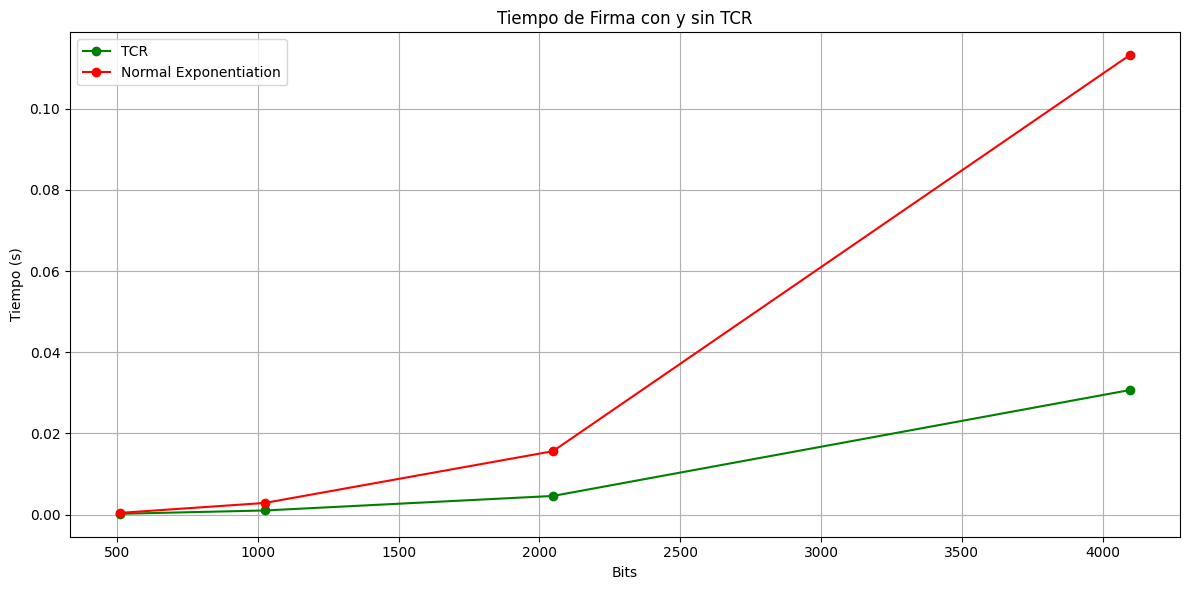

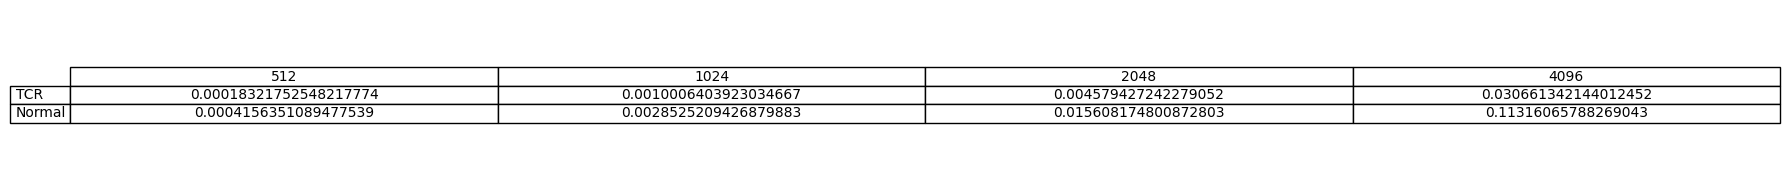

In [10]:
# Gráfico de líneas
fig, ax = plt.subplots(figsize=(12, 6))

# Datos para el gráfico
y1 = list(mean_TCR_times.values())
y2 = list(mean_SLOW_times.values())
bits = list(mean_TCR_times.keys())

# Gráfico de líneas
ax.plot(bits, y1, '-o', label="TCR", color='green')
ax.plot(bits, y2, '-o', label="Normal Exponentiation", color='red')
ax.set_title('Tiempo de Firma con y sin TCR')
ax.set_xlabel('Bits')
ax.set_ylabel('Tiempo (s)')
ax.legend(loc="upper left")
ax.grid(True)

plt.tight_layout()
plt.show()

# Crear una figura y un eje para la tabla
fig, ax = plt.subplots(figsize=(18, 2))

# Ocultar el eje
ax.axis('tight')
ax.axis('off')

# Crear la tabla
table_data = [y1, y2]
row_labels = ['TCR', 'Normal']
col_labels = bits
table = ax.table(cellText=table_data, rowLabels=row_labels, colLabels=col_labels, cellLoc='center', loc='center')

# Ajustar el diseño
plt.tight_layout()
plt.show()


Podemos ver como los tiempos aumentan exponencialmente con el tamaño de la clave en ambos casos. Esto es consistente con el hecho de que las operaciones de exponenciación modular en RSA son más costosas a medida que la longitud de la clave crece, debido al aumento en la cantidad de bits que procesar.

Para cada tamaño de clave, el tiempo con TCR es aproximadamente entre 2 y 4 veces menor que sin TCR. Esto es consistente con la teoría detrás del TCR, dado que sabemos que TCR divide el problema original en dos subproblemas de menor tamaño, y los resultados se combinan al final. La reducción en tamaño permite ahorrar tiempo en las operaciones.

Como sabemos, ambos metodos son cúbicos, sin embargo vemos como para calves de bits pequeñas, tenemos una gran diferencia:
- un speedup de ~44% en 512, 
- un speedup de ~36% en 1024,
- un speedup de ~30% en 2048 y
- un speedup de ~26% en 4096

Lo que cuadra con los costes asimptoticos computacionales que tienen ambos algoritmos dado que sabemos que sin TCR lo podemos hacer en O(k³) y con TCR tenemos un O(4k³/3) que asimptoticamente son iguales pero con numeros de bits pequeños vemos como la diferencia es mas que notable.

In [11]:
import os

def eval_block_chain(fichero_de_entrada):
    with open(fichero_de_entrada, 'r') as file:
        cadena_aux = eval(json.loads(file.read()))
    try:
        Cadena_bloques_valida = block_chain()
    except:
        claveRSA = rsa_key(1024)
        m = random.randint(0, 2**2048) % claveRSA.modulus
        aux = transaction(message=m, RSAkey=claveRSA)
        Cadena_bloques_valida = block_chain(aux)
    Cadena_bloques_valida.from_dictionary(cadena_aux)
    print(f"Verificando archivo {fichero_de_entrada}, verificación: {Cadena_bloques_valida.verify()}")

# Obtener todos los archivos de la carpeta BlockChain-20241127
carpeta = 'BlockChain-20241127'
archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta) if os.path.isfile(os.path.join(carpeta, f))]

# Llamar a eval_block_chain para cada archivo
for archivo in archivos:
    eval_block_chain(archivo)
    
# eval_block_chain('BlockChain_nombre1.apellido1_nombre2.apellido2.block')

Verificando archivo BlockChain-20241127/Cadena_bloques_seed_falsa.block, verificación: (False, 32)
Verificando archivo BlockChain-20241127/Cadena_bloques_bloque_falso.block, verificación: (False, 27)
Verificando archivo BlockChain-20241127/Cadena_bloques_valida.block, verificación: True
Verificando archivo BlockChain-20241127/Cadena_bloques_transaccion_falsa.block, verificación: (False, 6)


In [12]:
mensajes = [random.randint(0, 1000) for _ in range(100)]
RSAkey = rsa_key()

numero_de_bloques = 100
cadena = None

for i in range(numero_de_bloques):
    msg = mensajes[i]
    trans = transaction(message=msg, RSAkey=RSAkey)
    if cadena is None:
        cadena = block_chain(trans)
    else:
        cadena.add_block(trans)
    print(f"Verificando bloque {i}, verificación: {cadena.verify()}")
    
print(f"Verificación de la cadena de bloques: {cadena.verify()}")
with open('BlockChain_jordi.munoz.yiqi.zheng.block', 'w') as file:
    file.write(json.dumps(cadena.__repr__()))
    

Verificando bloque 0, verificación: True
Verificando bloque 1, verificación: True
Verificando bloque 2, verificación: True
Verificando bloque 3, verificación: True
Verificando bloque 4, verificación: True
Verificando bloque 5, verificación: True
Verificando bloque 6, verificación: True
Verificando bloque 7, verificación: True
Verificando bloque 8, verificación: True
Verificando bloque 9, verificación: True
Verificando bloque 10, verificación: True
Verificando bloque 11, verificación: True
Verificando bloque 12, verificación: True
Verificando bloque 13, verificación: True
Verificando bloque 14, verificación: True
Verificando bloque 15, verificación: True
Verificando bloque 16, verificación: True
Verificando bloque 17, verificación: True
Verificando bloque 18, verificación: True
Verificando bloque 19, verificación: True
Verificando bloque 20, verificación: True
Verificando bloque 21, verificación: True
Verificando bloque 22, verificación: True
Verificando bloque 23, verificación: True
Ve

In [13]:
mensajes = [random.randint(0, 1000) for _ in range(100)]
RSAkey = rsa_key()

numero_de_bloques = 100
bloques_validos = 33
cadena = None

for i in range(numero_de_bloques):
    msg = mensajes[i]
    trans = transaction(message=msg, RSAkey=RSAkey)
    if cadena is None:
        cadena = block_chain(trans)
    elif i > bloques_validos:
        cadena.add_invalid_block(trans)
    else:
        cadena.add_block(trans)
    print(f"Verificando bloque {i}, verificación: {cadena.verify()}")
    
print(f"Verificación de la cadena de bloques: {cadena.verify()}")
with open('BlockChain_jordi.munoz.yiqi.zheng.block', 'w') as file:
    file.write(json.dumps(cadena.__repr__()))
    

Verificando bloque 0, verificación: True
Verificando bloque 1, verificación: True
Verificando bloque 2, verificación: True
Verificando bloque 3, verificación: True
Verificando bloque 4, verificación: True
Verificando bloque 5, verificación: True
Verificando bloque 6, verificación: True
Verificando bloque 7, verificación: True
Verificando bloque 8, verificación: True
Verificando bloque 9, verificación: True
Verificando bloque 10, verificación: True
Verificando bloque 11, verificación: True
Verificando bloque 12, verificación: True
Verificando bloque 13, verificación: True
Verificando bloque 14, verificación: True
Verificando bloque 15, verificación: True
Verificando bloque 16, verificación: True
Verificando bloque 17, verificación: True
Verificando bloque 18, verificación: True
Verificando bloque 19, verificación: True
Verificando bloque 20, verificación: True
Verificando bloque 21, verificación: True
Verificando bloque 22, verificación: True
Verificando bloque 23, verificación: True
Ve

In [2]:
print(len("1648666289676221257287944568867596903509718952804799866046474835649509286"))

73
